# Browse TD-MPC2 runs (local + W&B)

Examples for working with `discover/runs.py` from a notebook. Run this notebook from the repo root or the `discover/` directory.

## Setup
- Update `logs_dir` if your logs live elsewhere.
- Set `wandb_project` to fetch remote runs.
- Cached merged runs are stored in `discover/runs_cache.parquet` with the latest timestamp.

In [14]:
from pathlib import Path
from datetime import datetime
import sys
import json
import pandas as pd

# Make sure repo root is importable when running from this notebook directory
ROOT = Path('..').resolve()
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

from discover.runs import discover_local_logs, discover_wandb_runs

logs_dir = ROOT / 'tdmpc2' / 'logs'
wandb_project = 'wm-planning/mmbench'  # entity/project
wandb_limit = None  # no limit
cache_path = ROOT / 'discover' / 'runs_cache.parquet'
cache_meta_path = ROOT / 'discover' / 'runs_cache.meta.txt'


In [15]:
def load_local_runs(logs_path: Path, limit: int | None = None) -> pd.DataFrame:
    return discover_local_logs(logs_path, limit=limit)


def load_wandb_runs(project_path: str, *, limit: int | None = None, include_artifacts: bool = False) -> pd.DataFrame:
    return discover_wandb_runs(project_path, limit=limit, include_artifacts=include_artifacts)


def combine_runs(*dfs: pd.DataFrame) -> pd.DataFrame:
    frames = [df for df in dfs if df is not None and not df.empty]
    return pd.concat(frames, ignore_index=True, sort=False) if frames else pd.DataFrame()


def latest_timestamp(df: pd.DataFrame) -> datetime:
    if 'updated_at' not in df.columns or df.empty:
        return datetime.now()
    ts = pd.to_datetime(df['updated_at'], errors='coerce').dropna()
    return ts.max() if not ts.empty else datetime.now()


def normalize_for_save(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty:
        return df
    out = df.copy()
    text_cols = [
        'task', 'exp_name', 'seed', 'source', 'ckpt_path', 'run_dir', 'url',
        'wandb_run_id', 'run_id', 'state', 'user', 'config_path'
    ]
    for col in text_cols:
        if col in out.columns:
            out[col] = out[col].astype(str)

    def to_json_cell(x):
        if x is None:
            return None
        try:
            if pd.isna(x):
                return None
        except (TypeError, ValueError):
            # isna can fail on lists/arrays or complex objects; treat as not-na
            pass
        return json.dumps(x, default=str)

    list_like = ['videos', 'tags', 'artifacts', 'summary']
    for col in list_like:
        if col in out.columns:
            out[col] = out[col].apply(to_json_cell)

    if 'updated_at' in out.columns:
        out['updated_at'] = out['updated_at'].astype(str)
    return out


def save_cache(df: pd.DataFrame, data_path: Path, meta_path: Path) -> datetime:
    data_path.parent.mkdir(parents=True, exist_ok=True)
    df_norm = normalize_for_save(df)
    df_norm.to_parquet(data_path, index=False)
    ts = latest_timestamp(df)
    meta_path.write_text(ts.isoformat())
    return ts


def load_cache(data_path: Path, meta_path: Path) -> tuple[pd.DataFrame | None, datetime | None]:
    if not data_path.is_file() or not meta_path.is_file():
        return None, None
    df = pd.read_parquet(data_path)
    try:
        ts = datetime.fromisoformat(meta_path.read_text().strip())
    except Exception:
        ts = None
    return df, ts


def load_all_runs(
    logs_dir: Path,
    *,
    wandb_project: str,
    wandb_limit: int | None = None,
    include_artifacts: bool = False,
) -> tuple[pd.DataFrame, datetime]:
    local_df = load_local_runs(logs_dir)
    wandb_df = load_wandb_runs(
        wandb_project,
        limit=wandb_limit,
        include_artifacts=include_artifacts,
    )
    df_all = combine_runs(local_df, wandb_df)
    return df_all, latest_timestamp(df_all)


def load_or_refresh_runs(*, refresh: bool = False) -> tuple[pd.DataFrame, datetime, bool]:
    cached_df, cached_ts = load_cache(cache_path, cache_meta_path)
    if cached_df is not None and not refresh:
        return cached_df, cached_ts, True

    df_all, new_ts = load_all_runs(
        logs_dir,
        wandb_project=wandb_project,
        wandb_limit=wandb_limit,
        include_artifacts=False,
    )

    if cached_df is not None and cached_ts is not None and new_ts <= cached_ts:
        return cached_df, cached_ts, True

    saved_ts = save_cache(df_all, cache_path, cache_meta_path)
    return df_all, saved_ts, False


def attach_runtime(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty:
        return df.assign(runtime=pd.Series(dtype='float'))

    out = df.copy()
    if 'summary' not in out.columns:
        out['runtime'] = pd.Series(dtype='float')
        return out

    def _runtime(summary):
        if isinstance(summary, dict):
            # Prefer 'runtime', fallback to '_runtime' (common wandb key)
            return summary.get('runtime', summary.get('_runtime'))
        return None

    out['runtime'] = pd.to_numeric(out['summary'].apply(_runtime), errors='coerce')
    return out


def attach_max_step(df: pd.DataFrame) -> pd.DataFrame:
    """Add a 'max_step' column that combines ckpt_step (local) and summary['_step'] (wandb)."""
    if df.empty:
        return df.assign(max_step=pd.Series(dtype='float'))

    out = df.copy()

    def _get_step(row):
        # First try ckpt_step (from local runs)
        if pd.notna(row.get('ckpt_step')):
            return row['ckpt_step']
        # Then try summary['_step'] (from wandb)
        summary = row.get('summary')
        if isinstance(summary, dict):
            return summary.get('_step')
        return None

    out['max_step'] = out.apply(_get_step, axis=1)
    out['max_step'] = pd.to_numeric(out['max_step'], errors='coerce')
    return out


def best_step_by_task(df: pd.DataFrame) -> pd.DataFrame:
    """Select the run with the maximum step for each task."""
    if df.empty:
        return df
    df_with_step = attach_max_step(df)
    filled = df_with_step['max_step'].fillna(-1)
    idx = filled.groupby(df_with_step['task']).idxmax()
    return df_with_step.loc[idx].sort_values('task')


def best_runtime_by_task(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty:
        return df
    filled = df['runtime'].fillna(-1)
    idx = filled.groupby(df['task']).idxmax()
    return df.loc[idx].sort_values('task')


def best_runtime_table(df: pd.DataFrame) -> pd.DataFrame:
    df_rt = attach_runtime(df)
    if df_rt.empty:
        return df_rt
    best = best_runtime_by_task(df_rt)
    cols = [
        'task',
        'runtime',
        'exp_name',
        'seed',
        'source',
        'ckpt_path',
        'ckpt_step',
        'url',
        'run_dir',
        'summary',
    ]
    present = [c for c in cols if c in best.columns]
    return best[present]


def plot_max_steps(df: pd.DataFrame, target_step: int | None = None) -> None:
    """Plot the max step per task to see training progress.
    
    Args:
        df: DataFrame with all runs (will compute best step per task internally)
        target_step: Optional target step to show as vertical line (e.g. 5_000_000 for completion)
    """
    best = best_step_by_task(df)
    if best.empty:
        print('No runs found.')
        return
    if 'max_step' not in best.columns or best['max_step'].isna().all():
        print('No step data available to plot.')
        return

    plot_df = best[['task', 'max_step']].copy().sort_values('max_step', ascending=True)
    import matplotlib.pyplot as plt

    # Scale height: ~0.2 inches per task, minimum 8 inches
    n_tasks = len(plot_df)
    fig_height = max(8, n_tasks * 0.2)
    fig, ax = plt.subplots(figsize=(14, fig_height))
    bars = ax.barh(plot_df['task'], plot_df['max_step'].fillna(0))

    # Color bars based on progress
    if target_step:
        for bar, step in zip(bars, plot_df['max_step']):
            if pd.isna(step) or step == 0:
                bar.set_color('red')  # not started or crashed
            elif step >= target_step:
                bar.set_color('green')  # completed
            else:
                bar.set_color('orange')  # in progress
        ax.axvline(x=target_step, color='green', linestyle='--', linewidth=2, label=f'Target: {target_step:,}')
        ax.legend()

    ax.set_xlabel('Max training step')
    ax.set_title('Training progress per task (max step reached)')
    ax.ticklabel_format(style='plain', axis='x')  # Avoid scientific notation
    ax.tick_params(axis='y', labelsize=8)  # Smaller font for many tasks
    plt.tight_layout()
    plt.show()


def plot_ckpt_steps(best_by_task: pd.DataFrame) -> None:
    """Deprecated: use plot_max_steps instead."""
    if best_by_task is None or best_by_task.empty:
        print('best_by_task is empty; run the previous cells first.')
        return
    if 'ckpt_step' not in best_by_task.columns:
        print('ckpt_step column not available to plot.')
        return
    plot_df = best_by_task[['task', 'ckpt_step']].copy().sort_values('task')
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, max(4, len(plot_df) * 0.25)))
    plt.barh(plot_df['task'], plot_df['ckpt_step'])
    plt.xlabel('ckpt_step')
    plt.title('Best run per task: checkpoint step')
    plt.tight_layout()


df_all, latest_ts, used_cache = load_or_refresh_runs(refresh=False)
print(f'Total rows: {len(df_all)}')
print(f"Using cache: {used_cache}, latest timestamp: {latest_ts}")
df_all.head()

Total rows: 4106
Using cache: True, latest timestamp: 2025-12-10 06:32:43.966566


,source,task,seed,exp_name,run_dir,ckpt_path,ckpt_step,updated_at,videos,config_path,wandb_run_id,run_id,state,tags,user,url,summary,artifacts
0,local,reacher-hard,1,expert_reacher-hard,/home/projects/dharel/nadavt/repos/newt/tdmpc2...,/home/projects/dharel/nadavt/repos/newt/tdmpc2...,3800000.0,2025-12-09T12:04:24.487996,[],None,None,nan,nan,None,nan,nan,None,None
1,local,reacher-hard,1,expert_reacher-hard,/home/projects/dharel/nadavt/repos/newt/tdmpc2...,/home/projects/dharel/nadavt/repos/newt/tdmpc2...,2700000.0,2025-12-09T01:17:38.339315,[],None,None,nan,nan,None,nan,nan,None,None
2,local,reacher-hard,1,expert_reacher-hard,/home/projects/dharel/nadavt/repos/newt/tdmpc2...,/home/projects/dharel/nadavt/repos/newt/tdmpc2...,1100000.0,2025-12-08T09:28:12.393685,[],None,None,nan,nan,None,nan,nan,None,None
3,local,reacher-hard,1,expert_reacher-hard,/home/projects/dharel/nadavt/repos/newt/tdmpc2...,/home/projects/dharel/nadavt/repos/newt/tdmpc2...,2900000.0,2025-12-09T03:16:39.182672,[],None,None,nan,nan,None,nan,nan,None,None
4,local,reacher-hard,1,expert_reacher-hard,/home/projects/dharel/nadavt/repos/newt/tdmpc2...,/home/projects/dharel/nadavt/repos/newt/tdmpc2...,3600000.0,2025-12-09T10:06:20.427796,[],None,None,nan,nan,None,nan,nan,None,None


In [16]:
# # Re-run after changing wandb_project/wandb_limit or to force refresh.
# df_all, latest_ts, used_cache = load_or_refresh_runs(refresh=True)
# print(f"Total rows: {len(df_all)}")
# print(f"Using cache: {used_cache}, latest timestamp: {latest_ts}")
# df_all.head()

## Training progress per task
For each task, find the run with the maximum training step to see progress. Steps are extracted from `ckpt_step` (local runs) or `summary['_step']` (W&B runs).

Color coding in the plot:
- 🟢 **Green**: Completed (reached target step)
- 🟠 **Orange**: In progress
- 🔴 **Red**: Not started or crashed (0 steps)

In [17]:
# Get the run with max step for each task
best_by_task = best_step_by_task(df_all)

if best_by_task.empty:
    print('No runs found; populate logs_dir or enable do_wandb.')
else:
    # Display relevant columns
    cols = ['task', 'max_step', 'exp_name', 'seed', 'source', 'ckpt_path', 'url', 'run_dir']
    present = [c for c in cols if c in best_by_task.columns]
    display(best_by_task[present])

,task,max_step,exp_name,seed,source,ckpt_path,url,run_dir
2561,acrobot-swingup,5000000.0,expert_acrobot-swingup,1,local,/home/projects/dharel/nadavt/repos/newt/tdmpc2...,nan,/home/projects/dharel/nadavt/repos/newt/tdmpc2...
3477,atari-alien,NaN,expert_atari-alien,1,wandb,nan,https://wandb.ai/wm-planning/mmbench/runs/4mqs...,nan
3511,atari-assault,NaN,expert_atari-assault,1,wandb,nan,https://wandb.ai/wm-planning/mmbench/runs/ae7l...,nan
3509,atari-asterix,NaN,expert_atari-asterix,1,wandb,nan,https://wandb.ai/wm-planning/mmbench/runs/ut0h...,nan
3514,atari-atlantis,NaN,expert_atari-atlantis,1,wandb,nan,https://wandb.ai/wm-planning/mmbench/runs/d8n9...,nan
...,...,...,...,...,...,...,...,...
3048,walker-run,5000000.0,expert_walker-run,1,local,/home/projects/dharel/nadavt/repos/newt/tdmpc2...,nan,/home/projects/dharel/nadavt/repos/newt/tdmpc2...
1843,walker-run-backward,3800000.0,expert_walker-run-backward,1,local,/home/projects/dharel/nadavt/repos/newt/tdmpc2...,nan,/home/projects/dharel/nadavt/repos/newt/tdmpc2...
207,walker-stand,5000000.0,expert_walker-stand,1,local,/home/projects/dharel/nadavt/repos/newt/tdmpc2...,nan,/home/projects/dharel/nadavt/repos/newt/tdmpc2...
959,walker-walk,5000000.0,expert_run,1,local,/home/projects/dharel/nadavt/repos/newt/tdmpc2...,nan,/home/projects/dharel/nadavt/repos/newt/tdmpc2...


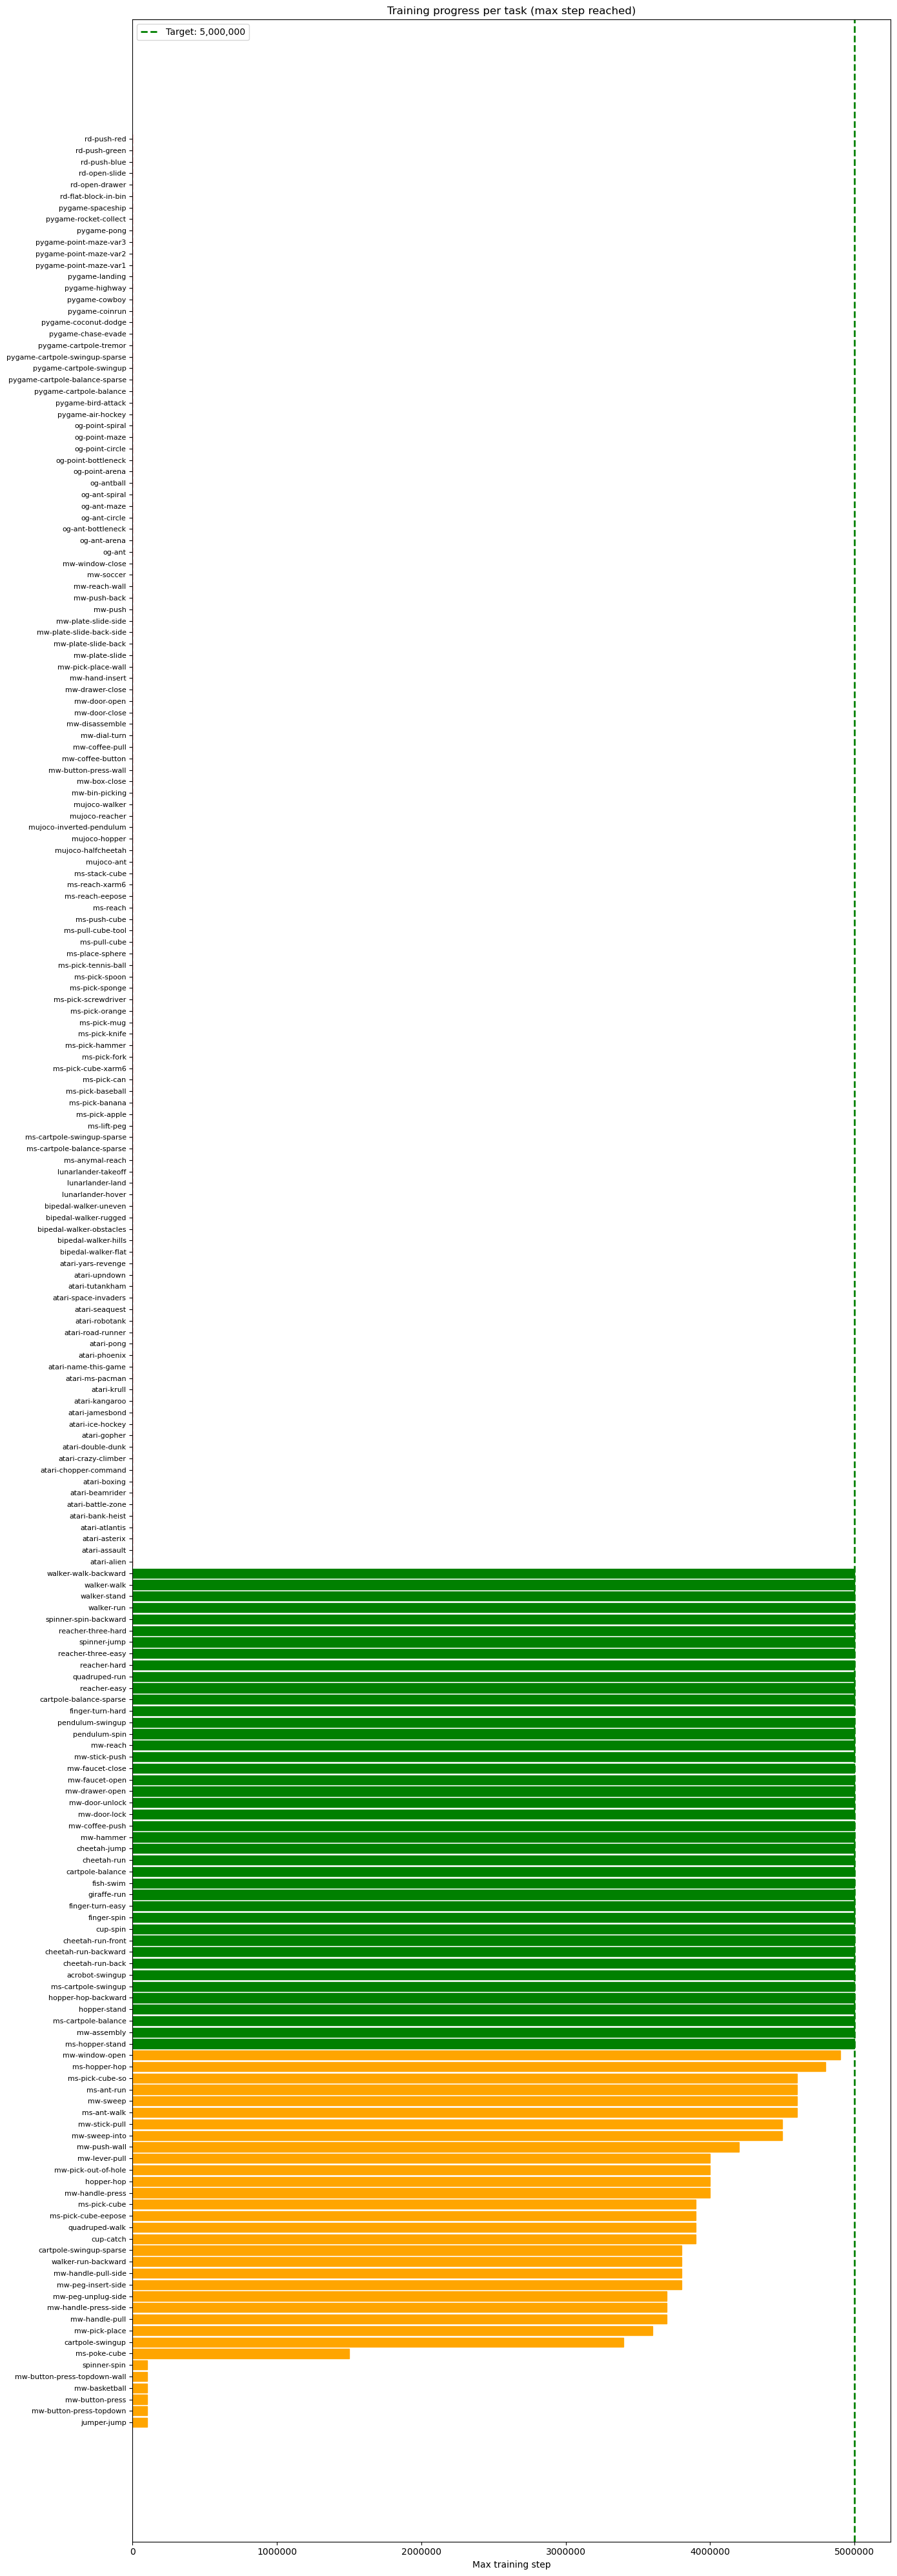

In [18]:
# Plot training progress - set target_step to your expected completion step
# Green = completed, Orange = in progress, Red = not started/crashed
plot_max_steps(df_all, target_step=5_000_000)

## Training Progress Overview
Aggregate statistics and distributions to quickly assess overall training status.

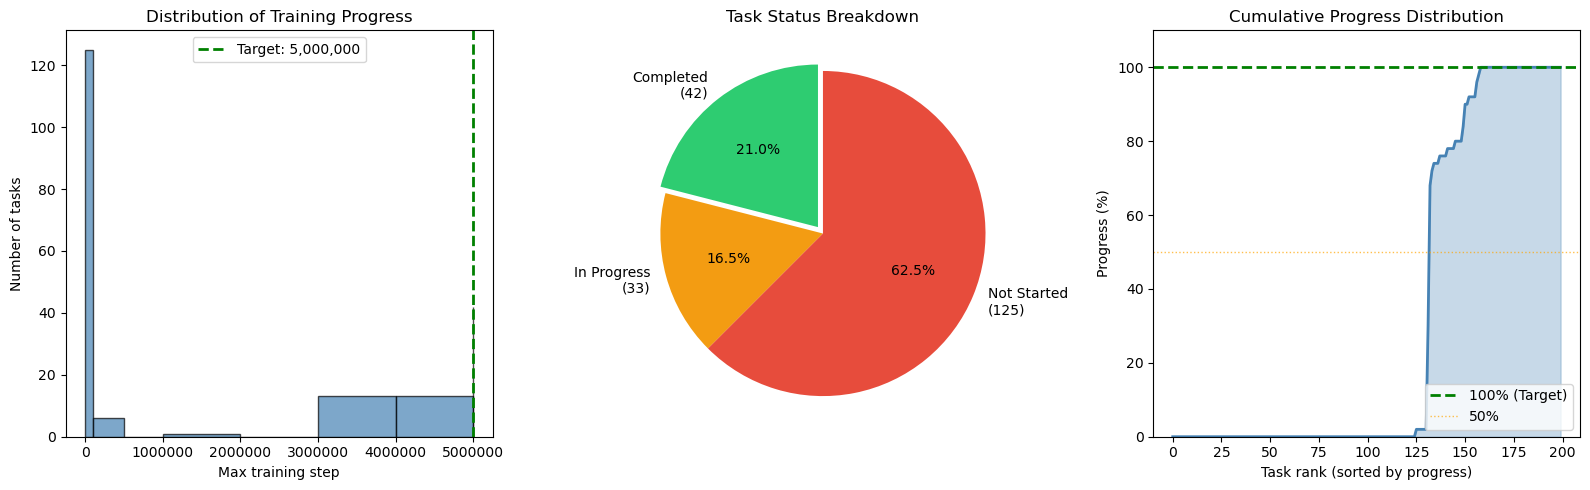

                 TRAINING PROGRESS SUMMARY                  
  Total tasks:            200
  Target step:         5,000,000
------------------------------------------------------------
  ✅ Completed:            42 (21.0%)
  🔄 In Progress:          33 (16.5%)
  ❌ Not Started:         125 (62.5%)
------------------------------------------------------------
  Average progress:      31.8%
  Median progress:        0.0%
  Min steps:                0
  Max steps:           5,000,000


In [19]:
def training_overview(df: pd.DataFrame, target_step: int = 5_000_000) -> None:
    """Generate overview statistics and visualizations for training progress."""
    import matplotlib.pyplot as plt
    
    best = best_step_by_task(df)
    if best.empty:
        print('No runs found.')
        return
    
    steps = best['max_step'].fillna(0)
    n_tasks = len(steps)
    
    # Categorize tasks
    completed = (steps >= target_step).sum()
    in_progress = ((steps > 0) & (steps < target_step)).sum()
    not_started = (steps == 0).sum()
    
    # Calculate stats
    pct_complete = 100 * completed / n_tasks
    avg_progress = 100 * steps.mean() / target_step
    median_progress = 100 * steps.median() / target_step
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    # 1. Histogram of max steps
    ax1 = axes[0]
    bins = [0, 100_000, 500_000, 1_000_000, 2_000_000, 3_000_000, 4_000_000, 5_000_000, steps.max() + 1]
    ax1.hist(steps, bins=bins, edgecolor='black', alpha=0.7, color='steelblue')
    ax1.axvline(x=target_step, color='green', linestyle='--', linewidth=2, label=f'Target: {target_step:,}')
    ax1.set_xlabel('Max training step')
    ax1.set_ylabel('Number of tasks')
    ax1.set_title('Distribution of Training Progress')
    ax1.ticklabel_format(style='plain', axis='x')
    ax1.legend()
    
    # 2. Pie chart of status
    ax2 = axes[1]
    sizes = [completed, in_progress, not_started]
    labels = [f'Completed\n({completed})', f'In Progress\n({in_progress})', f'Not Started\n({not_started})']
    colors = ['#2ecc71', '#f39c12', '#e74c3c']
    explode = (0.05, 0, 0)
    wedges, texts, autotexts = ax2.pie(
        sizes, labels=labels, colors=colors, explode=explode,
        autopct='%1.1f%%', startangle=90, textprops={'fontsize': 10}
    )
    ax2.set_title('Task Status Breakdown')
    
    # 3. Progress distribution (cumulative)
    ax3 = axes[2]
    progress_pct = 100 * steps / target_step
    progress_pct = progress_pct.clip(upper=100)  # Cap at 100%
    sorted_progress = progress_pct.sort_values().reset_index(drop=True)
    ax3.fill_between(range(len(sorted_progress)), sorted_progress, alpha=0.3, color='steelblue')
    ax3.plot(sorted_progress.values, color='steelblue', linewidth=2)
    ax3.axhline(y=100, color='green', linestyle='--', linewidth=2, label='100% (Target)')
    ax3.axhline(y=50, color='orange', linestyle=':', linewidth=1, alpha=0.7, label='50%')
    ax3.set_xlabel('Task rank (sorted by progress)')
    ax3.set_ylabel('Progress (%)')
    ax3.set_title('Cumulative Progress Distribution')
    ax3.set_ylim(0, 110)
    ax3.legend(loc='lower right')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("=" * 60)
    print(f"{'TRAINING PROGRESS SUMMARY':^60}")
    print("=" * 60)
    print(f"  Total tasks:         {n_tasks:>6}")
    print(f"  Target step:         {target_step:>6,}")
    print("-" * 60)
    print(f"  ✅ Completed:        {completed:>6} ({pct_complete:.1f}%)")
    print(f"  🔄 In Progress:      {in_progress:>6} ({100*in_progress/n_tasks:.1f}%)")
    print(f"  ❌ Not Started:      {not_started:>6} ({100*not_started/n_tasks:.1f}%)")
    print("-" * 60)
    print(f"  Average progress:    {avg_progress:>6.1f}%")
    print(f"  Median progress:     {median_progress:>6.1f}%")
    print(f"  Min steps:           {int(steps.min()):>6,}")
    print(f"  Max steps:           {int(steps.max()):>6,}")
    print("=" * 60)


# Run the overview
training_overview(df_all, target_step=5_000_000)

## Tasks Requiring Attention
Identify tasks that may need intervention (crashed, stuck, or significantly behind).

In [20]:
def tasks_needing_attention(df: pd.DataFrame, target_step: int = 5_000_000, bottom_n: int = 20) -> None:
    """Show tasks that may need attention: not started, crashed, or significantly behind."""
    best = best_step_by_task(df)
    if best.empty:
        print('No runs found.')
        return
    
    steps = best['max_step'].fillna(0)
    
    # Tasks not started (0 steps)
    not_started = best[steps == 0][['task', 'max_step']].copy()
    
    # Tasks in progress but behind (bottom N by step count, excluding not started and completed)
    in_progress = best[(steps > 0) & (steps < target_step)].copy()
    behind = in_progress.nsmallest(bottom_n, 'max_step')[['task', 'max_step']].copy()
    behind['progress'] = (100 * behind['max_step'] / target_step).round(1).astype(str) + '%'
    
    print("=" * 70)
    print(f"{'TASKS REQUIRING ATTENTION':^70}")
    print("=" * 70)
    
    if not not_started.empty:
        print(f"\n❌ NOT STARTED ({len(not_started)} tasks):")
        print("-" * 70)
        for task in not_started['task'].tolist():
            print(f"   • {task}")
    else:
        print("\n✅ All tasks have started training!")
    
    if not behind.empty:
        print(f"\n🐢 LAGGING TASKS (bottom {len(behind)} by progress):")
        print("-" * 70)
        for _, row in behind.iterrows():
            steps_str = f"{int(row['max_step']):,}"
            print(f"   • {row['task']:<45} {steps_str:>12} ({row['progress']})")
    
    # Show recently updated tasks (last 24h) that might indicate active training
    if 'updated_at' in best.columns:
        try:
            best_copy = best.copy()
            best_copy['updated_at_dt'] = pd.to_datetime(best_copy['updated_at'], errors='coerce')
            cutoff = datetime.now() - pd.Timedelta(hours=24)
            recent = best_copy[best_copy['updated_at_dt'] > cutoff]
            active_count = len(recent)
            if active_count > 0:
                print(f"\n📊 RECENT ACTIVITY: {active_count} tasks updated in last 24 hours")
        except Exception:
            pass
    
    print("\n" + "=" * 70)


# Show tasks needing attention
tasks_needing_attention(df_all, target_step=5_000_000, bottom_n=15)

                      TASKS REQUIRING ATTENTION                       

❌ NOT STARTED (125 tasks):
----------------------------------------------------------------------
   • atari-alien
   • atari-assault
   • atari-asterix
   • atari-atlantis
   • atari-bank-heist
   • atari-battle-zone
   • atari-beamrider
   • atari-boxing
   • atari-chopper-command
   • atari-crazy-climber
   • atari-double-dunk
   • atari-gopher
   • atari-ice-hockey
   • atari-jamesbond
   • atari-kangaroo
   • atari-krull
   • atari-ms-pacman
   • atari-name-this-game
   • atari-phoenix
   • atari-pong
   • atari-road-runner
   • atari-robotank
   • atari-seaquest
   • atari-space-invaders
   • atari-tutankham
   • atari-upndown
   • atari-yars-revenge
   • bipedal-walker-flat
   • bipedal-walker-hills
   • bipedal-walker-obstacles
   • bipedal-walker-rugged
   • bipedal-walker-uneven
   • lunarlander-hover
   • lunarlander-land
   • lunarlander-takeoff
   • ms-anymal-reach
   • ms-cartpole-balance-sparse
   • 

## Progress by Task Domain
Group tasks by their prefix/domain to see which categories are further along.

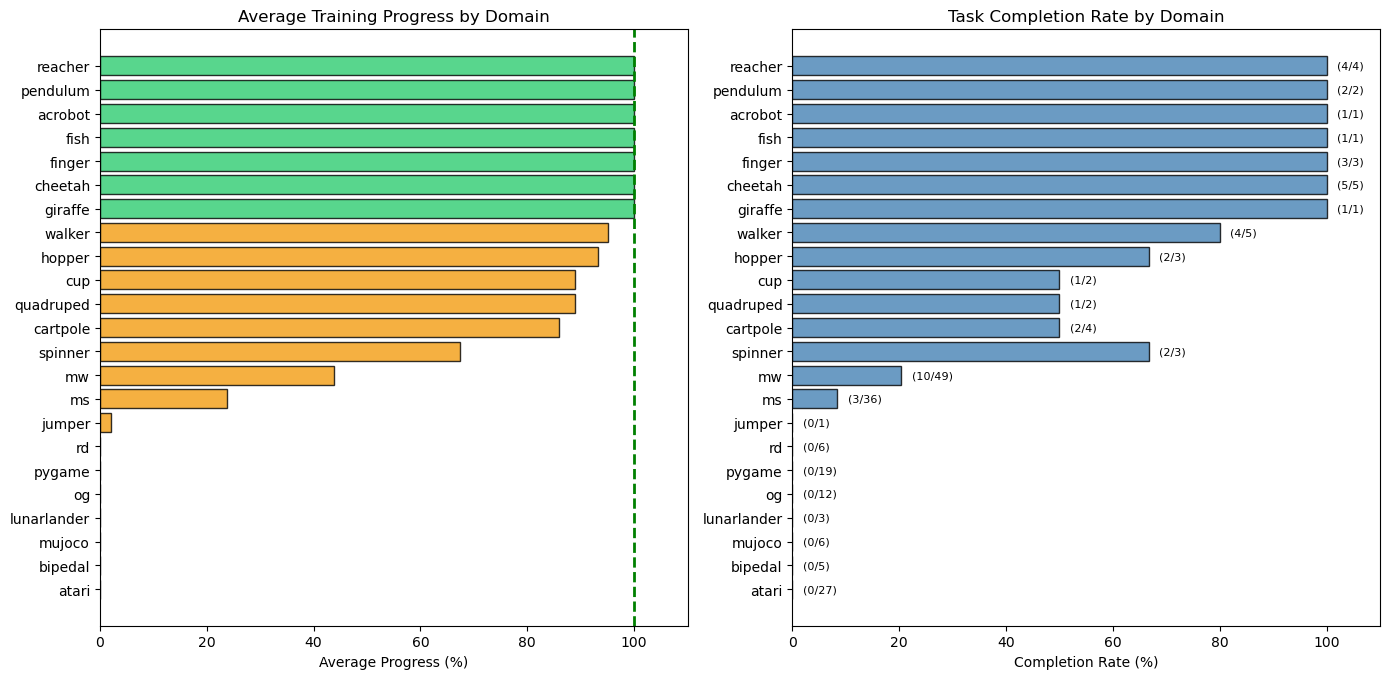


Domain Summary:
--------------------------------------------------------------------------------
Domain                  Tasks   Complete   Avg Progress   Completion %
--------------------------------------------------------------------------------
giraffe                     1          1         100.0%         100.0%
finger                      3          3         100.0%         100.0%
cheetah                     5          5         100.0%         100.0%
pendulum                    2          2         100.0%         100.0%
acrobot                     1          1         100.0%         100.0%
reacher                     4          4         100.0%         100.0%
fish                        1          1         100.0%         100.0%
walker                      5          4          95.2%          80.0%
hopper                      3          2          93.3%          66.7%
cup                         2          1          89.0%          50.0%
quadruped                   2          1

In [21]:
def progress_by_domain(df: pd.DataFrame, target_step: int = 5_000_000) -> None:
    """Group tasks by domain prefix and show aggregate progress."""
    import matplotlib.pyplot as plt
    
    best = best_step_by_task(df)
    if best.empty:
        print('No runs found.')
        return
    
    # Extract domain from task name (first part before hyphen or underscore)
    def get_domain(task: str) -> str:
        # Common prefixes to detect
        for sep in ['-', '_']:
            if sep in task:
                return task.split(sep)[0]
        return task
    
    best_copy = best.copy()
    best_copy['domain'] = best_copy['task'].apply(get_domain)
    best_copy['progress_pct'] = (100 * best_copy['max_step'].fillna(0) / target_step).clip(upper=100)
    best_copy['is_complete'] = best_copy['max_step'] >= target_step
    
    # Aggregate by domain
    domain_stats = best_copy.groupby('domain').agg({
        'task': 'count',
        'max_step': 'mean',
        'progress_pct': 'mean',
        'is_complete': 'sum'
    }).rename(columns={
        'task': 'n_tasks',
        'max_step': 'avg_steps',
        'progress_pct': 'avg_progress',
        'is_complete': 'n_complete'
    })
    domain_stats['completion_rate'] = 100 * domain_stats['n_complete'] / domain_stats['n_tasks']
    domain_stats = domain_stats.sort_values('avg_progress', ascending=True)
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(14, max(5, len(domain_stats) * 0.3)))
    
    # Bar chart of average progress by domain
    ax1 = axes[0]
    colors = ['#2ecc71' if p >= 100 else '#f39c12' if p > 0 else '#e74c3c' 
              for p in domain_stats['avg_progress']]
    ax1.barh(domain_stats.index, domain_stats['avg_progress'], color=colors, edgecolor='black', alpha=0.8)
    ax1.axvline(x=100, color='green', linestyle='--', linewidth=2)
    ax1.set_xlabel('Average Progress (%)')
    ax1.set_title('Average Training Progress by Domain')
    ax1.set_xlim(0, 110)
    
    # Bar chart of completion rate by domain
    ax2 = axes[1]
    ax2.barh(domain_stats.index, domain_stats['completion_rate'], color='steelblue', edgecolor='black', alpha=0.8)
    ax2.set_xlabel('Completion Rate (%)')
    ax2.set_title('Task Completion Rate by Domain')
    ax2.set_xlim(0, 110)
    
    # Add task count annotations
    for i, (idx, row) in enumerate(domain_stats.iterrows()):
        ax2.text(row['completion_rate'] + 2, i, f"({int(row['n_complete'])}/{int(row['n_tasks'])})", 
                va='center', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary table
    print("\nDomain Summary:")
    print("-" * 80)
    print(f"{'Domain':<20} {'Tasks':>8} {'Complete':>10} {'Avg Progress':>14} {'Completion %':>14}")
    print("-" * 80)
    for idx, row in domain_stats.sort_values('avg_progress', ascending=False).iterrows():
        print(f"{idx:<20} {int(row['n_tasks']):>8} {int(row['n_complete']):>10} "
              f"{row['avg_progress']:>13.1f}% {row['completion_rate']:>13.1f}%")
    print("-" * 80)


# Show progress by domain
progress_by_domain(df_all, target_step=5_000_000)

## Tasks Ready for Evaluation (50%+ trained)
List tasks that have completed at least 50% of training and check if they already have videos.

In [22]:
def tasks_ready_for_eval(df: pd.DataFrame, target_step: int = 5_000_000, min_progress: float = 0.5):
    """Find tasks that are at least min_progress (e.g., 50%) trained and check video availability."""
    min_step = int(target_step * min_progress)
    
    best = best_step_by_task(df)
    if best.empty:
        print('No runs found.')
        return pd.DataFrame(), [], []
    
    # Filter to tasks at or above min_progress
    ready = best[best['max_step'] >= min_step].copy()
    
    # Check for videos - need to look at local runs for video paths
    def has_videos(row):
        videos = row.get('videos')
        if isinstance(videos, list) and len(videos) > 0:
            return True
        if isinstance(videos, str):
            try:
                import json
                v = json.loads(videos)
                return isinstance(v, list) and len(v) > 0
            except:
                return False
        return False
    
    def get_video_paths(row):
        videos = row.get('videos')
        if isinstance(videos, list):
            return videos
        if isinstance(videos, str):
            try:
                import json
                return json.loads(videos)
            except:
                return []
        return []
    
    ready['has_videos'] = ready.apply(has_videos, axis=1)
    ready['video_paths'] = ready.apply(get_video_paths, axis=1)
    ready['progress_pct'] = (100 * ready['max_step'] / target_step).round(1)
    
    # Sort by progress
    ready = ready.sort_values('max_step', ascending=False)
    
    # Split into with/without videos
    with_videos = ready[ready['has_videos']]
    without_videos = ready[~ready['has_videos']]
    
    print("=" * 80)
    print(f"{'TASKS READY FOR EVALUATION (≥' + str(int(min_progress*100)) + '% trained)':^80}")
    print("=" * 80)
    print(f"\nTotal tasks at ≥{int(min_progress*100)}%: {len(ready)}")
    print(f"  ✅ With videos:    {len(with_videos)}")
    print(f"  ❌ Without videos: {len(without_videos)}")
    
    # Display table
    display_cols = ['task', 'max_step', 'progress_pct', 'has_videos', 'source', 'ckpt_path']
    present = [c for c in display_cols if c in ready.columns]
    
    print(f"\n{'─' * 80}")
    print("Tasks WITH videos:")
    print("─" * 80)
    if not with_videos.empty:
        for _, row in with_videos.iterrows():
            status = "✅"
            print(f"  {status} {row['task']:<45} {int(row['max_step']):>10,} ({row['progress_pct']}%)")
    else:
        print("  (none)")
    
    print(f"\n{'─' * 80}")
    print("Tasks WITHOUT videos (need eval):")
    print("─" * 80)
    if not without_videos.empty:
        for _, row in without_videos.iterrows():
            status = "❌"
            print(f"  {status} {row['task']:<45} {int(row['max_step']):>10,} ({row['progress_pct']}%)")
    else:
        print("  (none - all tasks have videos!)")
    
    print("=" * 80)
    
    # Return lists for scripting
    tasks_need_eval = without_videos['task'].tolist()
    tasks_with_videos = with_videos['task'].tolist()
    
    return ready, tasks_need_eval, tasks_with_videos


# Get tasks ready for eval (50%+ trained)
ready_df, tasks_need_eval, tasks_with_videos = tasks_ready_for_eval(df_all, target_step=5_000_000, min_progress=0.5)
print(f"\nTasks needing eval: {len(tasks_need_eval)}")
print(f"Tasks with videos: {len(tasks_with_videos)}")

                   TASKS READY FOR EVALUATION (≥50% trained)                    

Total tasks at ≥50%: 68
  ✅ With videos:    0
  ❌ Without videos: 68

────────────────────────────────────────────────────────────────────────────────
Tasks WITH videos:
────────────────────────────────────────────────────────────────────────────────
  (none)

────────────────────────────────────────────────────────────────────────────────
Tasks WITHOUT videos (need eval):
────────────────────────────────────────────────────────────────────────────────
  ❌ acrobot-swingup                                5,000,000 (100.0%)
  ❌ cartpole-balance                               5,000,000 (100.0%)
  ❌ cartpole-balance-sparse                        5,000,000 (100.0%)
  ❌ cheetah-jump                                   5,000,000 (100.0%)
  ❌ reacher-easy                                   5,000,000 (100.0%)
  ❌ cheetah-run                                    5,000,000 (100.0%)
  ❌ cheetah-run-back                     

## Generate Eval Script for Tasks Without Videos
Creates a task list file and LSF script to run evaluation on tasks that need videos.

In [23]:
def generate_eval_script(tasks: list[str], output_dir: Path = None):
    """Generate task list and LSF script to run eval on tasks without videos."""
    if output_dir is None:
        output_dir = ROOT / 'tdmpc2' / 'jobs'
    output_dir = Path(output_dir)
    
    if not tasks:
        print("✅ No tasks need evaluation - all have videos!")
        return
    
    # Write task list
    task_list_path = output_dir / 'tasks_need_eval.txt'
    task_list_path.write_text('\n'.join(tasks) + '\n')
    print(f"✅ Written task list to: {task_list_path}")
    print(f"   ({len(tasks)} tasks)")
    
    # Generate LSF script
    lsf_script = f'''#!/bin/bash
# Auto-generated eval script for tasks needing videos
# Generated: {datetime.now().isoformat()}
# Tasks: {len(tasks)}

#BSUB -J newt-eval-videos[1-{len(tasks)}]
#BSUB -q long-gpu
#BSUB -n 1
#BSUB -gpu "num=1"
#BSUB -R "rusage[mem=16GB]"
#BSUB -W 04:00
#BSUB -o /home/projects/dharel/nadavt/repos/newt/tdmpc2/logs/lsf/newt-eval-videos.%J.%I.log
#BSUB -e /home/projects/dharel/nadavt/repos/newt/tdmpc2/logs/lsf/newt-eval-videos.%J.%I.log

#BSUB -app nvidia-gpu
#BSUB -env "LSB_CONTAINER_IMAGE=ops:5000/newt:1.0.0"

cd /home/projects/dharel/nadavt/repos/newt/tdmpc2

pip install -q "wandb[media]"

# Select the task for this array index
TASK=$(sed -n "${{LSB_JOBINDEX}}p" jobs/tasks_need_eval.txt)
echo "LSF job index: ${{LSB_JOBINDEX}}, task: ${{TASK}}"

# Find the latest checkpoint
eval $(python - <<'PY'
from pathlib import Path
from jobs.eval_latest_checkpoints import parse_step

task = "${{TASK}}"
logs_dir = Path("logs") / task
candidates = sorted(logs_dir.glob("*/*/models/*.pt"))
if not candidates:
    print('CKPT=')
    print('EXP=')
else:
    best = max(candidates, key=parse_step)
    exp = best.parent.parent.name
    print(f'CKPT="{{best}}"')
    print(f'EXP="eval_{{exp}}_{{best.stem}}"')
PY
)

if [ -z "${{CKPT}}" ]; then
  echo "No checkpoint found for task '${{TASK}}', skipping."
  exit 0
fi

echo "Evaluating checkpoint: ${{CKPT}}"

python train.py \\
  task="${{TASK}}" \\
  model_size=B \\
  checkpoint="${{CKPT}}" \\
  steps=1 \\
  num_envs=2 \\
  use_demos=False \\
  tasks_fp=/home/projects/dharel/nadavt/tasks.json \\
  exp_name="${{EXP}}" \\
  save_video=True \\
  env_mode=sync \\
  compile=False
'''
    
    lsf_path = output_dir / 'run_eval_need_videos.lsf'
    lsf_path.write_text(lsf_script)
    print(f"✅ Written LSF script to: {lsf_path}")
    
    print(f"\n📋 To submit the eval jobs, run:")
    print(f"   cd {output_dir.parent}")
    print(f"   bsub < jobs/run_eval_need_videos.lsf")
    
    return task_list_path, lsf_path


# Generate eval script for tasks without videos
if tasks_need_eval:
    generate_eval_script(tasks_need_eval)
else:
    print("✅ All 50%+ trained tasks already have videos!")

✅ Written task list to: /home/projects/dharel/nadavt/repos/newt/tdmpc2/jobs/tasks_need_eval.txt
   (68 tasks)
✅ Written LSF script to: /home/projects/dharel/nadavt/repos/newt/tdmpc2/jobs/run_eval_need_videos.lsf

📋 To submit the eval jobs, run:
   cd /home/projects/dharel/nadavt/repos/newt/tdmpc2
   bsub < jobs/run_eval_need_videos.lsf


## Collect Videos for Download
Gather all videos from tasks that are 50%+ trained into a single directory for easy download.

In [24]:
def collect_videos_for_download(
    df: pd.DataFrame, 
    target_step: int = 5_000_000, 
    min_progress: float = 0.5,
    output_dir: Path = None,
    create_symlinks: bool = True,
    generate_download_script: bool = True
):
    """Collect videos from tasks that are 50%+ trained into a single directory."""
    import shutil
    
    if output_dir is None:
        output_dir = ROOT / 'discover' / 'videos_for_presentation'
    output_dir = Path(output_dir)
    
    min_step = int(target_step * min_progress)
    best = best_step_by_task(df)
    ready = best[best['max_step'] >= min_step].copy()
    
    video_info = []
    
    for _, row in ready.iterrows():
        task = row['task']
        videos = row.get('videos')
        
        # Parse videos list
        video_list = []
        if isinstance(videos, list):
            video_list = videos
        elif isinstance(videos, str):
            try:
                import json
                video_list = json.loads(videos)
            except:
                pass
        
        if video_list:
            # Get the latest/best video (usually sorted by name/step)
            for video_path in video_list:
                video_info.append({
                    'task': task,
                    'max_step': row['max_step'],
                    'progress_pct': 100 * row['max_step'] / target_step,
                    'video_path': video_path,
                    'source': row.get('source', 'unknown')
                })
    
    if not video_info:
        print("❌ No videos found in tasks that are 50%+ trained.")
        print("   Run the eval script first to generate videos.")
        return None
    
    # Create output directory
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Collect unique videos (one per task - the latest)
    videos_by_task = {}
    for v in video_info:
        task = v['task']
        if task not in videos_by_task:
            videos_by_task[task] = v
        else:
            # Keep the one with higher step if same task
            if v['max_step'] > videos_by_task[task]['max_step']:
                videos_by_task[task] = v
    
    collected_videos = []
    for task, v in sorted(videos_by_task.items()):
        src = Path(v['video_path'])
        if not src.exists():
            print(f"⚠️  Video not found: {src}")
            continue
        
        # Create descriptive filename: task_step.mp4
        step_str = f"{int(v['max_step']):d}"
        dst_name = f"{task}_{step_str}.mp4"
        dst = output_dir / dst_name
        
        if create_symlinks:
            # Create symlink
            if dst.exists() or dst.is_symlink():
                dst.unlink()
            dst.symlink_to(src)
        else:
            # Copy file
            shutil.copy2(src, dst)
        
        collected_videos.append({
            'task': task,
            'step': int(v['max_step']),
            'progress': v['progress_pct'],
            'filename': dst_name,
            'source_path': str(src),
            'dest_path': str(dst)
        })
    
    print("=" * 80)
    print(f"{'VIDEOS COLLECTED FOR PRESENTATION':^80}")
    print("=" * 80)
    print(f"\n📁 Output directory: {output_dir}")
    print(f"   Total videos: {len(collected_videos)}")
    print(f"   Method: {'symlinks' if create_symlinks else 'copies'}")
    
    print(f"\n{'─' * 80}")
    print(f"{'Task':<45} {'Step':>12} {'Progress':>10}")
    print("─" * 80)
    for v in collected_videos:
        print(f"  {v['task']:<43} {v['step']:>12,} {v['progress']:>9.1f}%")
    print("─" * 80)
    
    # Generate download script
    if generate_download_script:
        # Create a script to download via rsync/scp
        download_script = f'''#!/bin/bash
# Download videos from remote server to local machine
# Generated: {datetime.now().isoformat()}
# Videos: {len(collected_videos)}

# Usage: ./download_videos.sh [local_destination]
# Default destination: ./presentation_videos/

DEST="${{1:-./presentation_videos}}"
REMOTE_HOST="your-server"  # Change this to your server hostname
REMOTE_PATH="{output_dir}"

mkdir -p "$DEST"

echo "Downloading {len(collected_videos)} videos to $DEST..."

# Option 1: rsync (recommended - preserves timestamps, shows progress)
rsync -avz --progress "$REMOTE_HOST:$REMOTE_PATH/*.mp4" "$DEST/"

# Option 2: scp (simpler, if rsync not available)
# scp "$REMOTE_HOST:$REMOTE_PATH/*.mp4" "$DEST/"

echo "Done! Videos saved to: $DEST"
ls -la "$DEST"
'''
        
        script_path = output_dir / 'download_videos.sh'
        script_path.write_text(download_script)
        script_path.chmod(0o755)
        
        # Also create a manifest CSV
        manifest_df = pd.DataFrame(collected_videos)
        manifest_path = output_dir / 'video_manifest.csv'
        manifest_df.to_csv(manifest_path, index=False)
        
        print(f"\n📄 Generated files:")
        print(f"   {script_path} - Download script template")
        print(f"   {manifest_path} - Video manifest (CSV)")
        
        print(f"\n📥 To download to your laptop:")
        print(f"   1. Edit the REMOTE_HOST in download_videos.sh")
        print(f"   2. Run: scp -r <server>:{output_dir} ./presentation_videos/")
        print(f"   Or:  rsync -avz <server>:{output_dir}/ ./presentation_videos/")
    
    print("=" * 80)
    
    return pd.DataFrame(collected_videos)


# Collect videos for presentation
videos_df = collect_videos_for_download(
    df_all, 
    target_step=5_000_000, 
    min_progress=0.5,
    create_symlinks=True
)

❌ No videos found in tasks that are 50%+ trained.
   Run the eval script first to generate videos.
